In [1]:
#conda install ipympl # enables using the interactive features of matplotlib in jupyter notebook
# conda install -c conda-forge matplotlib


In [2]:
import cv2 # module import name for opencv
import numpy as np
from scipy import interpolate 
import matplotlib.pyplot as plt 
# generates an ipywidget that renders plots in a control
%matplotlib widget 
from mpl_toolkits.mplot3d import Axes3D # 3D graphing

In [3]:
########## INPUT ##########

imageName = '3dprinted2'+'.png'

high = 1.5 # unit micron
low = -1.5  # unit micron

mode = 'area' #line or area


###############################################
# image reading
img = cv2.imread('/Users/huitingluo/CME502_Final_Project/AFM images/'+imageName)

# convert to GrayScale image
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ratio of scale bar and the range of grayscale values
ratio = (high-low)/(255-0)

Done


/var/folders/vq/20l1pnsx0x14psspgntpl2_m0000gn/T/ipykernel_10899/602251679.py:114: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


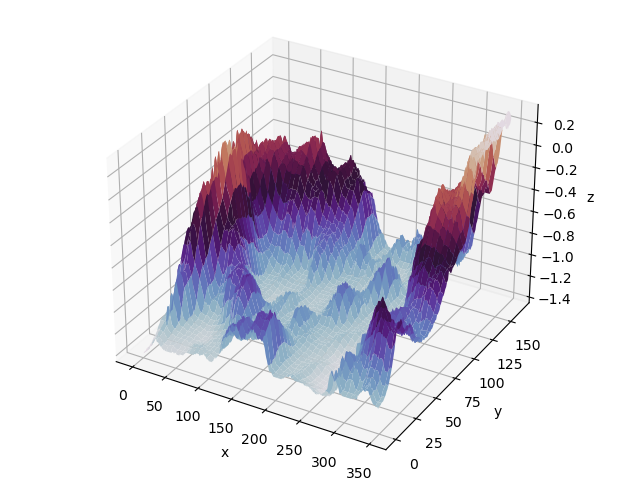

Ra Roughness:  0.2914133255959501 um


In [4]:

# Function: Pick Starting & ending points
def Pick_two_points(image, *args):  
    global counter
    counter = 0
    # Create point matrix get coordinates of mouse click on image   
    point_matrix = np.zeros((2,2),int)
    clone = image.copy()
    img = image.copy()
    def mousePoints(event,x,y,flags,params):
        global counter
        # Left button click
        if event == cv2.EVENT_LBUTTONDOWN: # indicates that the left mouse button is down
            if counter <2:
                point_matrix[counter] = x,y
                counter = counter + 1

        for x in range (0,2):
            #Draw circle on image with mouse click
            cv2.circle(img,(point_matrix[x][0],point_matrix[x][1]),8,(255,0,0),cv2.FILLED)
            cv2.putText(img,
                        'A' if x==0 else 'B',
                        (point_matrix[x][0]+10,point_matrix[x][1]-10),
                        cv2.FONT_HERSHEY_DUPLEX,
                        3.0,
                        (255,0,255),
                        3
                       )
            if counter == 2:
                # assign starting & ending points
                starting_x = point_matrix[0][0]
                starting_y = point_matrix[0][1]

                ending_x = point_matrix[1][0]
                ending_y = point_matrix[1][1]

                
                if 'line' in args:
                    # Draw line between starting & ending points
                    ImgWithMarker=cv2.line(img, (starting_x, starting_y), (ending_x, ending_y), (0, 255, 0), 3)
                if 'area' in args:
                # Draw rectangle for area of interest
                    ImgWithMarker=cv2.rectangle(img, (starting_x, starting_y), (ending_x, ending_y), (0, 255, 0), 3)
      
  # keep the image window active           
    while True:
        cv2.namedWindow('AFM', cv2.WINDOW_NORMAL)
        # Mouse click event on original image
#        cv2.resizeWindow('AFM', image.shape[1], image.shape[0])
        cv2.setMouseCallback('AFM', mousePoints)
        cv2.imshow('AFM', img) 
        key = cv2.waitKey(1) & 0xFF # maintain output window until user presses a key

         # if the 'r' key is pressed, <<<reset>>>> the region
        if key == ord("r") and counter ==2:
            counter = 0
            point_matrix = np.zeros((2,2),int)
            img = clone.copy()
        # if the 'enter' key is pressed, break from the loop
        elif key == ord("\r"):
            break

    print('Done')
#     cv2.destroyAllWindows() 
#     cv2.waitKey(1) #???? should distroy  or not 
                                            #confirm selection
    return point_matrix

#################################################################

StartEndPoints  = Pick_two_points(img, mode)

start_x = StartEndPoints[0][0]
start_y = StartEndPoints[0][1]
end_x = StartEndPoints[1][0]
end_y = StartEndPoints[1][1]

d_x = abs(end_x - start_x) # d_x : number of pixels at x axis
d_y = abs(end_y - start_y) # d_y : number of pixels at y axis

L = int(np.sqrt(d_x**2+d_y**2)+1) # L: Number of pixels in the line  

z_p = imgGray[min(start_y,end_y):max(start_y,end_y), min(start_x,end_x):max(start_x,end_x)]
z = high-ratio*(255-z_p)
# z = imgGray[min(start_y,end_y):max(start_y,end_y), min(start_x,end_x):max(start_x,end_x)] # start & end
#z = zg*100/255+50

if mode == 'line': # line interpolation

    f = interpolate.interp2d(np.arange(z.shape[1]), np.arange(z.shape[0]),  z, kind='linear')
    #f = interpolate.interp2d(x, y, z, kind='linear')

    Xnew = np.linspace(0,z.shape[1],L)
    Ynew = np.linspace(0,z.shape[0],L)
    Znew = f(Xnew,Ynew)
    if (start_x-end_x)*(start_y-end_y)<0:
        Z_dial = np.fliplr(Znew).diagonal()
        if start_y>end_y:
            Z_dial = Z_dial[::-1]
    else:
        Z_dial = np.diagonal(Znew)
    if start_x > end_x and start_y>end_y:
        Z_dial = Z_dial[::-1]
    plt.plot(Z_dial)
    
    Ra = np.sum(np.abs(Z_dial-np.mean(Z_dial)))/Z_dial.size
    
    
    
elif mode == 'area':
    x = np.arange(z.shape[1])
    y = np.arange(z.shape[0])
    X,Y = np.meshgrid(x,y)
    fig = plt.figure() 
    ax = Axes3D(fig) 
    ax.plot_surface(X, Y, z, cmap=plt.get_cmap('twilight'))
    ax.set_title("3d")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    #plt.savefig('3D.png') # save fig in the Main Folder
    plt.show()
    
    
    Ra = np.sum(np.abs(z-np.mean(z)))/z.size

print('Ra Roughness: ', Ra, 'um')